<a href="https://colab.research.google.com/github/Lizatol/Healthcare-Accessibility/blob/main/Healthcare_accessibility_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Block 1: Setup and Libraries**

In [1]:
# Block 1: Installing libraries and configuring the environment
!pip install osmnx mapclassify spopt pyomo openrouteservice pip install geopy folium -qqq

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import folium
from folium.plugins import MarkerCluster
import osmnx as ox
import openrouteservice
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

ERROR: Could not find a version that satisfies the requirement install (from versions: none)
ERROR: No matching distribution found for install
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Block 2: Load Administrative Boundaries**

In [2]:
# Block 2: Loading administrative borders
data_path = '/content/drive/MyDrive/ITMO materials/Python data/vsevolozhsk_admin_units_with_population_final.geojson'
adm_gdf = gpd.read_file(data_path)

# Centering the map
centroids = adm_gdf.geometry.centroid
m = folium.Map(location=[centroids.y.mean(), centroids.x.mean()], zoom_start=10)
folium.GeoJson(adm_gdf).add_to(m)
m

In [3]:
adm_gdf.head()

bbox_west  bbox_south  bbox_east  bbox_north   place_id  osm_type   osm_id  \
0  30.499309   59.945492  30.809409   60.139376  156312874  relation  1306580   
1  30.037111   60.135778  30.427486   60.345933  157162389  relation  1570867   
2  30.275602   60.049547  30.488091   60.173415  155496150  relation  1663038   
3  30.495419   59.886264  30.641510   59.977241  156188481  relation  1570684   
4  30.592366   59.812667  30.984683   59.995134  156594194  relation  1664811   

         lat        lon     class            type  place_rank  importance  \
0  60.042597  30.581805  boundary  administrative          14    0.236270   
1  60.240805  30.240227  boundary  administrative          14    0.246917   
2  60.111452  30.403904  boundary  administrative          14    0.245499   
3  59.931306  30.553954  boundary  administrative          14    0.250991   
4  59.905876  30.754165  boundary  administrative          14    0.269215   

    addresstype                            name  \
0  municipality                     Vsevolozhsk   
1  municipality  Agalatovskoye Rural Settlement   
2  municipality    Bugrovskoye Urban Settlement   
3  municipality     Zanevskoye Urban Settlement   
4  municipality   Koltushskoye Urban Settlement   

                                        display_name  population_2025  \
0  Vsevolozhsk, Vsevolozhsky District, Leningrad ...            79354   
1  Агалатовское сельское поселение, Vsevolozhsky ...            14416   
2  Бугровское городское поселение, Vsevolozhsky D...            39549   
3  Заневское городское поселение, Vsevolozhsky Di...            95402   
4  Колтушское городское поселение, Vsevolozhsky D...            30309   

                                            geometry  
0  POLYGON ((30.49931 60.04023, 30.49933 60.03945...  
1  POLYGON ((30.03711 60.30096, 30.03747 60.30072...  
2  POLYGON ((30.2756 60.10289, 30.2809 60.09974, ...  
3  POLYGON ((30.49542 59.89148, 30.49741 59.89136...  
4  POLYGON ((30.59237 59.92832, 30.60319 59.91924...

# **Block 3: Extract Residential Building Points**

In [4]:
def extract_buildings(adm_gdf):
    house_points = []
    for idx, row in tqdm(adm_gdf.iterrows(), total=len(adm_gdf)):
        try:
            buildings = ox.features_from_polygon(
                row.geometry,
                tags={'building': ['residential', 'house', 'apartments']}
            )
            if not buildings.empty:
                centroids = buildings.geometry.centroid
                for pt in centroids:
                    house_points.append({'settlement': row['name'], 'geometry': pt})
        except Exception:
            continue

    return gpd.GeoDataFrame(house_points, crs="EPSG:4326")

houses_gdf = extract_buildings(adm_gdf)
houses_gdf.explore()

100%|██████████| 18/18 [00:13<00:00,  1.32it/s]


# **Block 4: Compute Density-Based Centers**

In [5]:
def calculate_true_density_centers(adm_gdf, buildings_gdf, min_buildings=10):
    adm_gdf = adm_gdf.copy()
    adm_gdf['center_density'] = None
    for idx, row in tqdm(adm_gdf.iterrows(), total=len(adm_gdf)):
        area_buildings = buildings_gdf[buildings_gdf['settlement'] == row['name']]
        if len(area_buildings) < min_buildings:
            adm_gdf.at[idx, 'center_density'] = row.geometry.centroid
            continue
        try:
            coords = np.array([(pt.x, pt.y) for pt in area_buildings.geometry])
            kde = gaussian_kde(coords.T)
            x_min, y_min = coords.min(axis=0)
            x_max, y_max = coords.max(axis=0)
            x_grid, y_grid = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
            grid_coords = np.vstack([x_grid.ravel(), y_grid.ravel()])
            density = kde(grid_coords)
            max_idx = np.argmax(density)
            max_density_point = (grid_coords[0, max_idx], grid_coords[1, max_idx])
            adm_gdf.at[idx, 'center_density'] = gpd.points_from_xy(
                [max_density_point[0]], [max_density_point[1]]
            )[0]
        except Exception as e:
            print(f"Density error for {row['name']}: {e}")
            adm_gdf.at[idx, 'center_density'] = area_buildings.geometry.unary_union.centroid
    return adm_gdf

adm_gdf = calculate_true_density_centers(adm_gdf, houses_gdf)

100%|██████████| 18/18 [00:04<00:00,  4.38it/s]


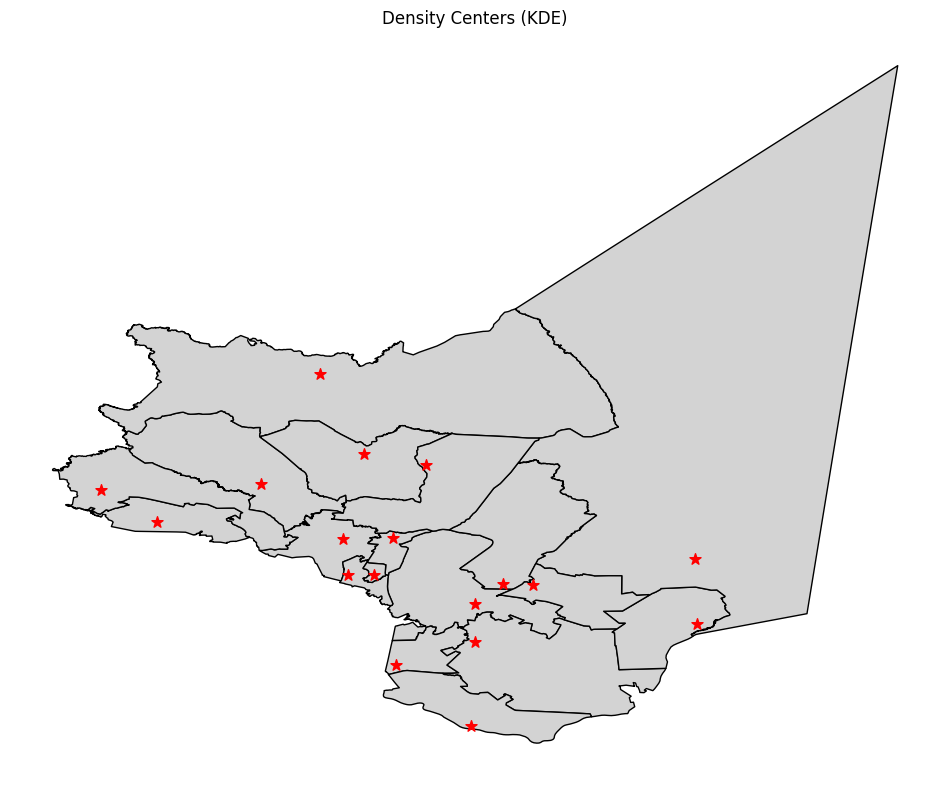

In [6]:
fig, ax = plt.subplots(figsize=(12, 10))
adm_gdf.plot(ax=ax, color='lightgrey', edgecolor='black')
gpd.GeoSeries(adm_gdf['center_density']).plot(ax=ax, color='red', markersize=70, marker='*')
plt.title('Density Centers (KDE)')
plt.axis('off')
plt.show()

# **Block 5: Extract and Classify Medical Facilities**

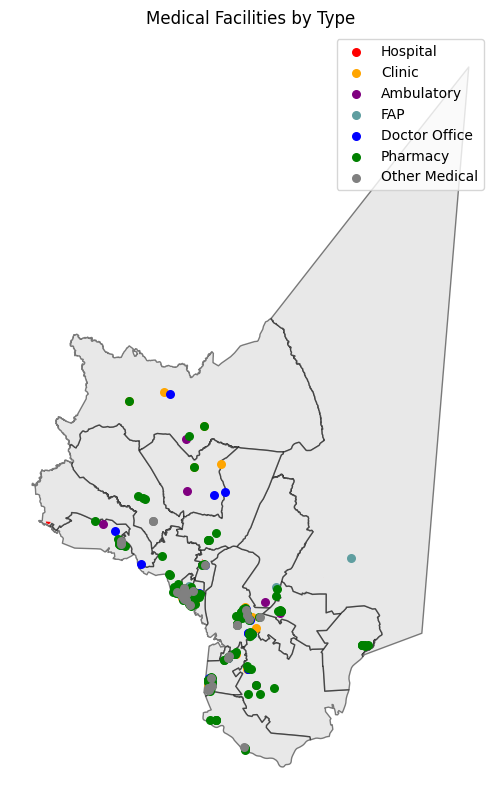

In [7]:
def get_medical_facilities(adm_gdf):
    area = adm_gdf.geometry.unary_union

    med_ox = ox.features_from_polygon(
        area,
        tags={
            'amenity': ['hospital', 'clinic', 'doctors', 'healthcare', 'pharmacy'],
            'healthcare': True
        }
    )

    # Classify function
    def classify(row):
        name = str(row.get('name', '')).lower()
        amenity = str(row.get('amenity', '')).lower()
        healthcare = str(row.get('healthcare', '')).lower()

        # Classification by types
        if any(x in name for x in ['скорая', 'emergency', 'неотложная']):
            return 'Emergency Care'
        if 'hospital' in amenity or 'hospital' in healthcare or any(x in name for x in ['больница', 'hospital', 'стационар']):
            if any(x in name for x in ['межрайон', 'regional', 'district', 'област', 'краевая', 'городская']):
                return 'Regional Hospital'
            return 'Hospital'
        if 'clinic' in amenity or 'clinic' in healthcare or any(x in name for x in ['clinic', 'поликлиника', 'клиника']):
            return 'Clinic'
        if any(x in name for x in ['ambulatory', 'амбулатория']):
            return 'Ambulatory'
        if any(x in name for x in ['фап', 'фельдшер', 'health post']):
            return 'FAP'
        if 'doctors' in amenity or 'doctor' in healthcare or any(x in name for x in ['врач', 'doctor']):
            return 'Doctor Office'
        if 'pharmacy' in amenity or 'аптека' in name or 'pharmacy' in name:
            return 'Pharmacy'
        return 'Other Medical'

    # GeoDataFrame
    med_ox['facility_type'] = med_ox.apply(classify, axis=1)
    med_gdf = gpd.GeoDataFrame(med_ox, geometry='geometry', crs=adm_gdf.crs)

    return med_gdf[~med_gdf.geometry.is_empty]

med_gdf = get_medical_facilities(adm_gdf)

# Visualization
fig, ax = plt.subplots(figsize=(12, 10))
adm_gdf.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)
facility_colors = {
    'Hospital': 'red',
    'Regional Hospital': 'darkred',
    'Clinic': 'orange',
    'Ambulatory': 'purple',
    'FAP': 'cadetblue',
    'Doctor Office': 'blue',
    'Pharmacy': 'green',
    'Emergency Care': 'black',
    'Other Medical': 'gray'
}

for facility_type, color in facility_colors.items():
    subset = med_gdf[med_gdf['facility_type'] == facility_type]
    if not subset.empty:
        subset.plot(ax=ax, color=color, markersize=30, label=facility_type)

plt.title('Medical Facilities by Type')
plt.legend(loc='best')
plt.axis('off')
plt.show()

# Interactive map

In [8]:
def create_interactive_map(adm_gdf, centers_gdf, facilities_gdf):
    adm_gdf = adm_gdf.to_crs(epsg=4326)
    centers_gdf = centers_gdf.to_crs(epsg=4326)
    facilities_gdf = facilities_gdf.to_crs(epsg=4326)

    centroid = adm_gdf.geometry.unary_union.centroid
    m = folium.Map(
        location=[centroid.y, centroid.x],
        zoom_start=10,
        tiles='CartoDB Positron',
        control_scale=True
    )

    def get_coords(geom):
        if geom is None:
            return None
        try:
            if hasattr(geom, 'x') and hasattr(geom, 'y'):
                return [geom.y, geom.x]
            if hasattr(geom, 'centroid'):
                return [geom.centroid.y, geom.centroid.x]
            return None
        except:
            return None

    # 1. Admin
    try:
        folium.GeoJson(
            adm_gdf[['name', 'geometry']].to_json(),
            name='Administrative Boundaries',
            style_function=lambda x: {
                'fillColor': '#ffffcc',
                'color': '#3186cc',
                'weight': 2,
                'fillOpacity': 0.2
            },
            tooltip=folium.GeoJsonTooltip(['name'])
        ).add_to(m)
    except Exception as e:
        print(f"Error with admin boundaries: {e}")

    # 2. Centers
    density_layer = folium.FeatureGroup(name='Calculated Density Centers', show=True)
    for _, row in centers_gdf.iterrows():
        try:
            coords = get_coords(row['center_density'])
            if coords:
                folium.CircleMarker(
                    location=coords,
                    radius=8,
                    color='purple',
                    fill=True,
                    fill_color='purple',
                    fill_opacity=0.7,
                    tooltip=f"Density Center: {row['name']}",
                    popup=f"Calculated density center for {row['name']}"
                ).add_to(density_layer)
        except Exception as e:
            print(f"Error adding density center for {row['name']}: {e}")
            continue

    density_layer.add_to(m)

    # 3. Healthcare
    colors = {
        'Hospital': 'red',
        'Regional Hospital': 'darkred',
        'Clinic': 'orange',
        'Ambulatory': 'purple',
        'FAP': 'cadetblue',
        'Doctor Office': 'blue',
        'Pharmacy': 'green',
        'Emergency Care': 'black',
        'Other Medical': 'gray'
    }

    for ftype, color in colors.items():
        ftype_layer = folium.FeatureGroup(name=f'Medical: {ftype}')
        facilities = facilities_gdf[facilities_gdf['facility_type'] == ftype]

        for _, facility in facilities.iterrows():
            try:
                coords = get_coords(facility.geometry)
                if coords:
                    folium.CircleMarker(
                        location=coords,
                        radius=6,
                        color=color,
                        fill=True,
                        fill_color=color,
                        fill_opacity=0.8,
                        popup=f"{ftype}: {facility.get('name', 'Unnamed')}"
                    ).add_to(ftype_layer)
            except:
                continue

        ftype_layer.add_to(m)

    # 4. Clusters (sum of healthcare)
    cluster = MarkerCluster(name='All Medical Facilities').add_to(m)
    for _, facility in facilities_gdf.iterrows():
        try:
            coords = get_coords(facility.geometry)
            if coords:
                folium.CircleMarker(
                    location=coords,
                    radius=5,
                    color=colors.get(facility['facility_type'], 'gray'),
                    fill=True,
                    fill_opacity=0.7,
                    popup=f"{facility['facility_type']}: {facility.get('name', 'Unnamed')}"
                ).add_to(cluster)
        except:
            continue

    # 7. Layer Control
    folium.LayerControl().add_to(m)

    return m

print("Creating...")
med_map = create_interactive_map(adm_gdf, adm_gdf, med_gdf)
print("Done!")
med_map

Creating...
Done!


# **Block 6: Routing and Accessibility Analysis**

100%|██████████| 18/18 [01:19<00:00,  4.42s/it]

Routes have been successfully calculated for:
['Vsevolozhsk' 'Agalatovskoye Rural Settlement'
 'Bugrovskoye Urban Settlement' 'Zanevskoye Urban Settlement'
 'Koltushskoye Urban Settlement' 'Kuzmolovskoye Urban Settlement'
 'Kuyvozovskoye Rural Settlement' 'Leskolovskoye Rural Settlement'
 'Morozovskoye Urban Settlement' 'Murinskoye Urban Settlement'
 'Novodevyatkinskoye Rural Settlement' 'Rakhinskoye Urban Settlement'
 'Romanovskoye Rural Settlement' 'Sverdlovskoye Urban Settlement'
 'Sertolovskoye Urban Settlement' 'Toksovskoye Urban Settlement'
 'Shcheglovskoye Rural Settlement' 'Yukkovskoye Rural Settlement']


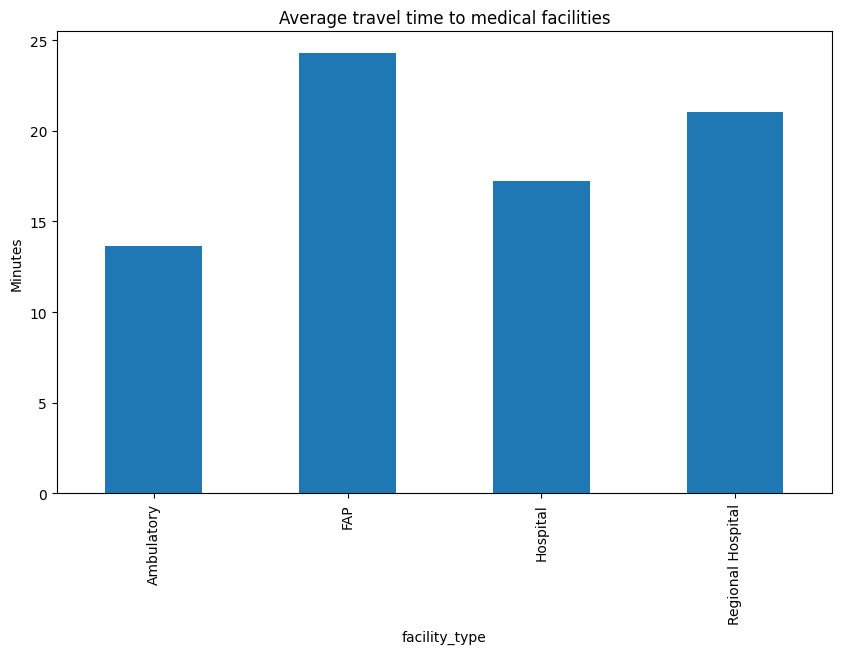

In [9]:
def calculate_nearest_facilities(centers_gdf, facilities_gdf, api_key, facility_types=None):
    import openrouteservice
    from tqdm import tqdm
    import time

    client = openrouteservice.Client(key=api_key)

    if facility_types:
        facilities = facilities_gdf[facilities_gdf['facility_type'].isin(facility_types)].copy()
    else:
        facilities = facilities_gdf.copy()

    # Data prepare
    facilities['coords'] = facilities.geometry.apply(
        lambda p: [p.x, p.y] if hasattr(p, 'x') else [p.centroid.x, p.centroid.y]
    )

    routes = []

    for _, center in tqdm(centers_gdf.iterrows(), total=len(centers_gdf)):
        try:
            center_coords = [center['center_density'].x, center['center_density'].y]

            # Nearest for each type
            for ftype in facilities['facility_type'].unique():
                type_facilities = facilities[facilities['facility_type'] == ftype]
                if len(type_facilities) == 0:
                    continue

                # Destinations
                destinations = type_facilities['coords'].tolist()

                # Distance matrix
                matrix = client.distance_matrix(
                    locations=[center_coords] + destinations,
                    profile='driving-car',
                    sources=[0],
                    destinations=list(range(1, len(destinations)+1)),
                    metrics=['distance', 'duration']
                )

                min_duration_idx = np.argmin(matrix['durations'][0])

                # Result
                routes.append({
                    'center_name': center['name'],
                    'facility_name': type_facilities.iloc[min_duration_idx]['name'],
                    'facility_type': ftype,
                    'distance_km': matrix['distances'][0][min_duration_idx] / 1000,
                    'duration_min': matrix['durations'][0][min_duration_idx] / 60
                })

            time.sleep(1)

        except Exception as e:
            print(f"Ошибка для центра {center['name']}: {str(e)}")
            continue

    return pd.DataFrame(routes)

try:
    ORS_API_KEY = "5b3ce3597851110001cf62486184497e620f4014950f13bbcbde4623"

    # Example for main types
    main_facility_types = ['Regional Hospital','Hospital', 'Ambulatory','FAP']
    routes_df = calculate_nearest_facilities(
        adm_gdf,
        med_gdf,
        ORS_API_KEY,
        facility_types=main_facility_types
    )

    if not routes_df.empty:
        print("Routes have been successfully calculated for:")
        print(routes_df['center_name'].unique())

        # Visualization of the average travel time
        plt.figure(figsize=(10, 6))
        routes_df.groupby('facility_type')['duration_min'].mean().plot.bar()
        plt.title('Average travel time to medical facilities')
        plt.ylabel('Minutes')
        plt.show()
    else:
        print("Couldn't calculate any routes")

except Exception as e:
    print(f"Error: {str(e)}")
    print("Check your API key")

In [19]:
def plot_routes_on_map(adm_gdf, routes_df, facilities_gdf):
    # Creating a map
    centroid = adm_gdf.geometry.unary_union.centroid
    m = folium.Map(
        location=[centroid.y, centroid.x],
        zoom_start=10,
        tiles='CartoDB Positron'
    )

    # 1. Function for safely extracting coordinates
    def get_coords(geom):
        if geom is None:
            return None
        try:
            if hasattr(geom, 'x') and hasattr(geom, 'y'):
                return [geom.y, geom.x]
            if hasattr(geom, 'centroid'):
                return [geom.centroid.y, geom.centroid.x]
            return None
        except:
            return None

    # 2. Administrative boundary layer (simplified version)
    for idx, row in adm_gdf.iterrows():
        try:
            folium.GeoJson(
                row.geometry.__geo_interface__,
                style_function=lambda x: {
                    'fillColor': '#ffffcc',
                    'color': '#3186cc',
                    'weight': 2,
                    'fillOpacity': 0.2
                },
                tooltip=row['name']
            ).add_to(m)
        except:
            continue

    # 3. The layer of medical institutions
    facility_colors = {
        'Hospital': 'red',
        'Clinic': 'orange',
        'Pharmacy': 'green'
    }

    for _, facility in facilities_gdf.iterrows():
        try:
            coords = get_coords(facility.geometry)
            if coords:
                folium.CircleMarker(
                    location=coords,
                    radius=6,
                    color=facility_colors.get(facility['facility_type'], 'gray'),
                    fill=True,
                    popup=f"{facility['facility_type']}: {facility.get('name', 'Unnamed')}"
                ).add_to(m)
        except:
            continue

    # 4. Route layer (the first 5 for example)
    for _, route in routes_df.head().iterrows():
        try:
            center = adm_gdf[adm_gdf['name'] == route['center_name']].iloc[0]
            center_coords = get_coords(center['center_density'])

            facility = facilities_gdf[facilities_gdf['name'] == route['facility_name']].iloc[0]
            facility_coords = get_coords(facility.geometry)

            if center_coords and facility_coords:
                folium.PolyLine(
                    locations=[center_coords, facility_coords],
                    color='blue',
                    weight=2,
                    popup=f"{route['duration_min']:.1f} мин до {route['facility_type']}"
                ).add_to(m)
        except Exception as e:
            print(f"Ошибка при отображении маршрута {route['center_name']} -> {route['facility_name']}: {str(e)}")
            continue

    return m

# Visualizing routes
try:
    if not routes_df.empty:
        print("Creating a route map...")
        route_map = plot_routes_on_map(adm_gdf.to_crs(epsg=4326),
                                     routes_df,
                                     med_gdf.to_crs(epsg=4326))
        print("Created successfully!")
        display(route_map)
    else:
        print("No route data for visualization")
except Exception as e:
    print(f"Critical error when creating a map: {str(e)}")

Creating a route map...
Created successfully!


# **Block 7: Integral Accessibility Index**

In [20]:
# 1. Population data
if 'population_2025' not in routes_df.columns:
    if 'population_2025' in adm_gdf.columns and 'name' in adm_gdf.columns:
        pop_dict = adm_gdf.set_index('name')['population_2025'].to_dict()
        routes_df['population_2025'] = routes_df['center_name'].map(pop_dict)
    else:
        print("Not enough data to add the population")
        routes_df['population_2025'] = 10000  # Default value

# 2. Check missings
missing_pop = routes_df['population_2025'].isna().sum()
if missing_pop > 0:
    print(f"Warning: {missing_pop} rows do not have population data!")

    if routes_df['population_2025'].notna().any():
        mean_pop = routes_df['population_2025'].mean()
    else:
        mean_pop = 10000

    routes_df['population_2025'] = routes_df['population_2025'].fillna(mean_pop)
    print(f"Filled with {missing_pop} gaps with the value: {mean_pop}")
else:
    print("Population data has been successfully added for all rows")

Population data has been successfully added for all rows


In [21]:
pop_dict = adm_gdf.set_index('name')['population_2025'].to_dict()
routes_df['population_2025'] = routes_df['center_name'].map(pop_dict)
if routes_df['population_2025'].isna().any():
    mean_pop = adm_gdf['population_2025'].mean()
    routes_df['population_2025'] = routes_df['population_2025'].fillna(mean_pop)
    print(f"Заполнено {routes_df['population_2025'].isna().sum()} пропусков средним значением населения")

In [23]:
# Checking the availability of all necessary columns
required_columns = ['duration_min', 'population_2025', 'facility_type', 'center_name']
for col in required_columns:
    if col not in routes_df.columns:
        print(f"Attention: the {col} column is missing")

# Checking
print(routes_df[['duration_min', 'population_2025']].dtypes)

# Filling in gaps in num_doctors if the column exists
if 'num_doctors' in routes_df.columns:
    routes_df['num_doctors'] = routes_df['num_doctors'].fillna(1)
else:
    routes_df['num_doctors'] = 1  # Only for testing!

duration_min       float64
population_2025      int64
dtype: object


In [24]:
# 1. Lists for classifying settlements
urban_names = ['Urban', 'Town', 'City', 'город', 'городское']  # Example of criteria for urban settlements
rural_names = ['Rural', 'Village', 'сельское', 'деревня']  # Example of criteria for rural settlements

# 2. Norms and Weights
TIME_NORMS = {
    'Hospital': 60,  # min
    'Regional Hospital': 60,
    'Ambulatory': 20,
    'FAP': 20,
    'Clinic': 30,
    'Pharmacy': 15,
    'Doctor Office': 30
}

MAX_PEOPLE_PER_DOCTOR = {
    'Hospital': 1500,
    'Regional Hospital': 1500,
    'Clinic': 2000,
    'Ambulatory': 2000,
    'FAP': 2500,
    'Pharmacy': 3000,
    'Doctor Office': 2500
}

# Weights
WEIGHTS = {
    'time': 0.5,    # Temporary availability
    'load': 0.2,    # The load on doctors
    'pop': 0.2,     # The population factor
    'law': 0.1      # Legislative norms
}
# 1. Function for safe conversion to scalar
def to_scalar(value, default=0):
    if isinstance(value, (list, tuple, np.ndarray)):
        return float(value[0]) if len(value) > 0 else default
    try:
        if pd.isna(value).any() if hasattr(value, '__iter__') else pd.isna(value):
            return default
        return float(value)
    except (ValueError, TypeError):
        return default

# 2. Preparing data with explicit conversion
def prepare_data(df):
    df_prep = df.copy()
    for col in ['duration_min', 'population_2025', 'num_doctors']:
        if col in df.columns:
            df_prep[col] = [to_scalar(x, 1 if col == 'num_doctors' else 0) for x in df[col]]
    return df_prep

# 3.
routes_df_prepared = prepare_data(routes_df)

def get_settlement_type(name):
    name_lower = str(name).lower()
    if any(term.lower() in name_lower for term in urban_names):
        return 'urban'
    elif any(term.lower() in name_lower for term in rural_names):
        return 'rural'
    else:
        return 'unknown'

# 4. Availability calculation function
def calculate_final_accessibility(row):
    try:
        duration = float(row['duration_min'])
        population = float(row['population_2025'])
        num_doctors = float(row.get('num_doctors', 1))
        facility_type = str(row['facility_type'])
        center_name = str(row['center_name'])

        time_norm = TIME_NORMS.get(facility_type, 60)
        time_factor = max(0, 1 - (duration / (2 * time_norm)))

        max_load = MAX_PEOPLE_PER_DOCTOR.get(facility_type, 2000)
        load_factor = 0 if num_doctors <= 0 else min(1, max_load / (population / max(1, num_doctors)))

        pop_factor = 0.8 if population > 10000 else 1.0
        law_factor = 1.0 if get_settlement_type(center_name) == 'urban' else 0.7

        return (
            WEIGHTS['time'] * time_factor +
            WEIGHTS['load'] * load_factor +
            WEIGHTS['pop'] * pop_factor +
            WEIGHTS['law'] * law_factor
        )
    except Exception as e:
        print(f"Error in row {row.name}: {str(e)}")
        return 0.5

# 5. Calculating the accessibility index
access_indices = []
for idx, row in routes_df_prepared.iterrows():
    access_indices.append(calculate_final_accessibility(row))

routes_df['access_index'] = [round(x * 100, 1) for x in access_indices]

# 6. Output of results
print("Top 10 most accessible routes:")
print(routes_df.sort_values('access_index', ascending=False).head(10)[[
    'center_name', 'facility_name', 'facility_type', 'duration_min', 'access_index'
]])

Top 10 most accessible routes:
                        center_name  \
61     Toksovskoye Urban Settlement   
35    Morozovskoye Urban Settlement   
45     Rakhinskoye Urban Settlement   
21   Kuzmolovskoye Urban Settlement   
67  Shcheglovskoye Rural Settlement   
48    Romanovskoye Rural Settlement   
65  Shcheglovskoye Rural Settlement   
37      Murinskoye Urban Settlement   
64  Shcheglovskoye Rural Settlement   
47     Rakhinskoye Urban Settlement   

                                     facility_name      facility_type  \
61                             Токсовская больница           Hospital   
35                  Морозовская городская больница  Regional Hospital   
45          Всеволожская КМБ, Ириновское отделение           Hospital   
21           Онкологический диспансер им.ЛД Романа           Hospital   
67   Всеволожская клиническая межрайонная больница  Regional Hospital   
48                           Амбулатория Романовка         Ambulatory   
65                          

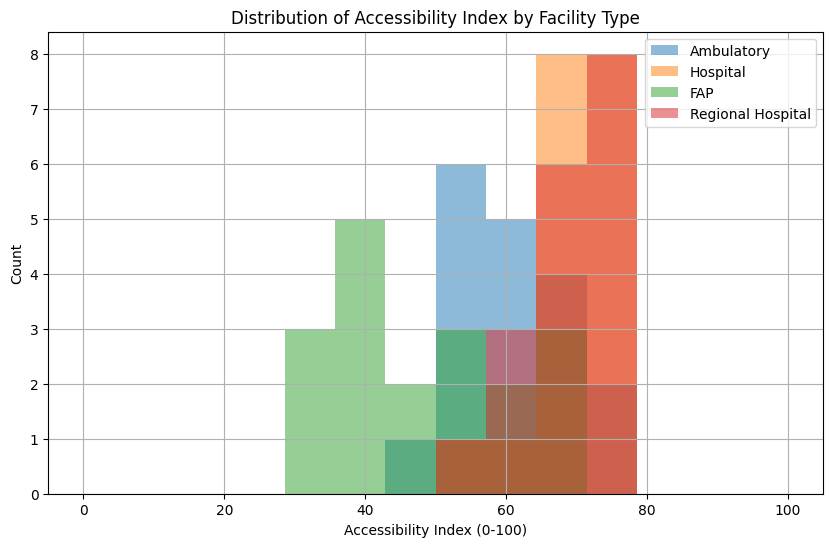

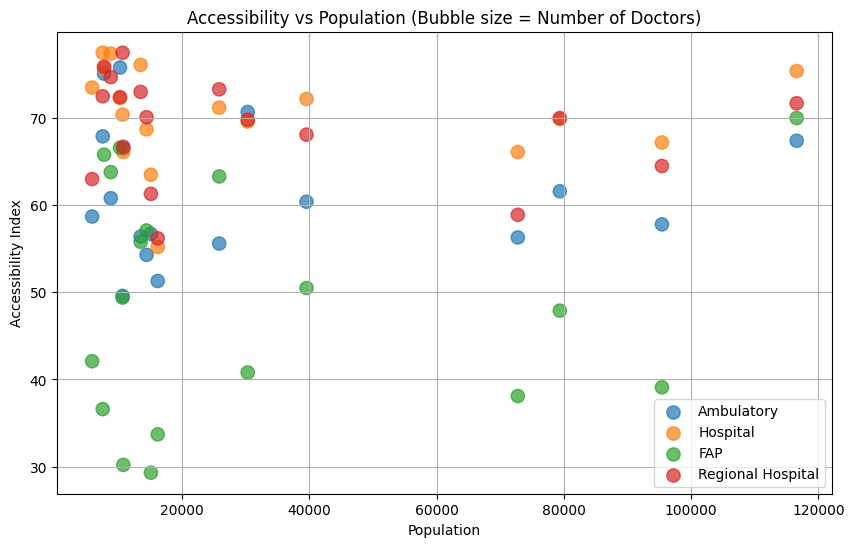

In [25]:
# 1. A function for converting sequences to scalars
def to_float(x):
    if isinstance(x, (list, tuple, np.ndarray)):
        return float(x[0]) if len(x) > 0 else np.nan
    try:
        return float(x)
    except (ValueError, TypeError):
        return np.nan

# 2. Data
def prepare_data(df):
    df = df.copy()
    for col in ['access_index', 'population_2025', 'num_doctors', 'duration_min']:
        if col in df.columns:
            df[col] = df[col].apply(to_float)
    return df

routes_df_clean = prepare_data(routes_df)

# 3. Accessibility histogram
plt.figure(figsize=(10,6))
for t in routes_df_clean['facility_type'].unique():
    data = routes_df_clean[routes_df_clean['facility_type'] == t]['access_index'].dropna()
    if len(data) > 0:
        plt.hist(data,
                 bins=np.linspace(0, 100, 15),
                 alpha=0.5,
                 label=t)
plt.xlabel("Accessibility Index (0-100)")
plt.ylabel("Count")
plt.title("Distribution of Accessibility Index by Facility Type")
plt.legend()
plt.grid(True)
plt.show()

# 4. Scatter plot
plt.figure(figsize=(10,6))
for t in routes_df_clean['facility_type'].unique():
    subset = routes_df_clean[routes_df_clean['facility_type'] == t]
    if len(subset) > 0:
        plt.scatter(
            subset['population_2025'].values,
            subset['access_index'].values,
            s=80 + subset['num_doctors'].values * 12,
            alpha=0.7,
            label=t
        )
plt.xlabel('Population')
plt.ylabel('Accessibility Index')
plt.title('Accessibility vs Population (Bubble size = Number of Doctors)')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
routes_sorted = routes_df.sort_values('access_index')
print("Top 5 with the least accessibility")
display(routes_sorted[['center_name','facility_type','access_index','duration_min','num_doctors','population_2025']].head(5))
print("Top 5 with the most accessibility")
display(routes_sorted[['center_name','facility_type','access_index','duration_min','num_doctors','population_2025']].tail(5))

Top 5 with the least accessibility


center_name facility_type  access_index  duration_min  \
54  Sverdlovskoye Urban Settlement           FAP          29.3     42.723500   
30  Leskolovskoye Rural Settlement           FAP          30.2     37.993833   
26  Kuyvozovskoye Rural Settlement           FAP          33.7     33.947333   
62    Toksovskoye Urban Settlement           FAP          36.6     40.357333   
58  Sertolovskoye Urban Settlement           FAP          38.1     30.856500   

    num_doctors  population_2025  
54            1            15092  
30            1            10761  
26            1            16166  
62            1             7525  
58            1            72752

Top 5 with the most accessibility


center_name      facility_type  access_index  \
67  Shcheglovskoye Rural Settlement  Regional Hospital          75.9   
21   Kuzmolovskoye Urban Settlement           Hospital          76.1   
45     Rakhinskoye Urban Settlement           Hospital          77.4   
61     Toksovskoye Urban Settlement           Hospital          77.5   
35    Morozovskoye Urban Settlement  Regional Hospital          77.5   

    duration_min  num_doctors  population_2025  
67     12.056000            1             7738  
21      4.994167            1            13480  
45     14.377167            1             8794  
61     15.538667            1             7525  
35      3.253500            1            10642

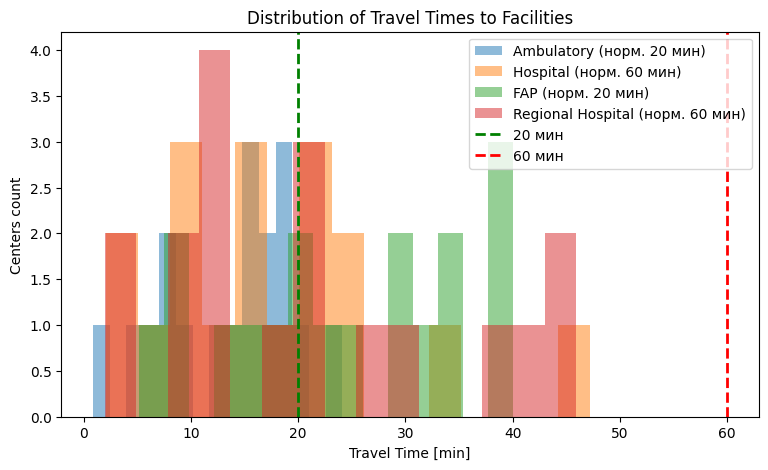

In [27]:
plt.figure(figsize=(9,5))
for t in routes_df['facility_type'].unique():
    times = routes_df[routes_df['facility_type']==t]['duration_min']
    norm = TIME_NORMS.get(t, 60)
    plt.hist([min(x, norm*2) for x in times], bins=15, alpha=0.5, label=f"{t} (норм. {norm} мин)")
plt.axvline(20, color='g', linestyle='--', lw=2, label='20 мин')
plt.axvline(60, color='r', linestyle='--', lw=2, label='60 мин')
plt.xlabel('Travel Time [min]')
plt.ylabel('Centers count')
plt.title('Distribution of Travel Times to Facilities')
plt.legend()
plt.show()

The average integral index of accessibility of medical care by district: 62.37


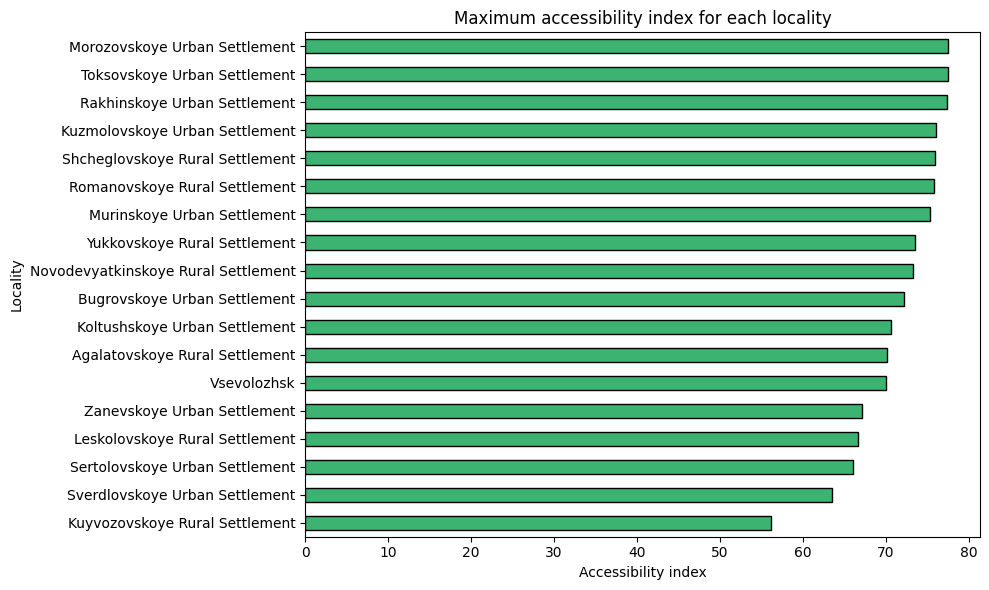

In [28]:
mean_index = routes_df['access_index'].mean()
print(f"The average integral index of accessibility of medical care by district: {mean_index:.2f}")

plt.figure(figsize=(10, 6))
routes_df.groupby('center_name')['access_index'].max().sort_values().plot(
    kind='barh',
    color='mediumseagreen',
    edgecolor='black'
)
plt.title("Maximum accessibility index for each locality")
plt.xlabel("Accessibility index")
plt.ylabel("Locality")
plt.tight_layout()
plt.show()
